In [1]:
import daspi as dsp
DPI = 120
dsp.__version__
dsp.STR.LANGUAGE = 'de'

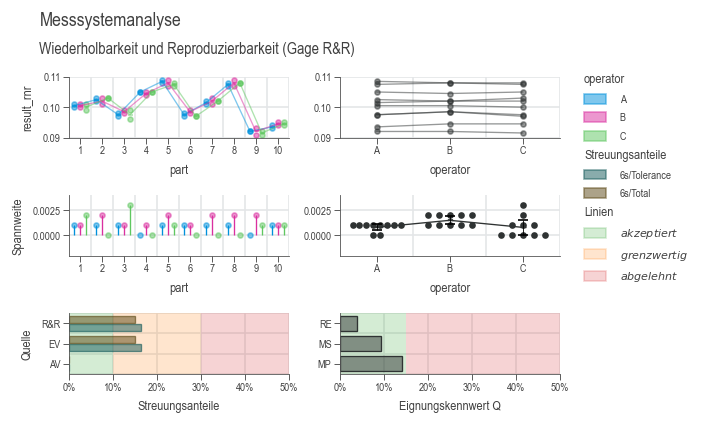

In [2]:
df = dsp.load_dataset('grnr_layer_thickness')
gage = dsp.GageEstimator(
    samples=df['result_gage'],
    reference=df['reference'][0],
    U_cal=df['U_cal'][0],
    tolerance=df['tolerance'][0],
    resolution=df['resolution'][0])
model = dsp.GageRnRModel(
    source=df,
    target='result_rnr',
    part='part',
    reproducer='operator',
    gage=gage)
chart = dsp.GageRnRCharts(model).plot().stripes().label()

In [ ]:
df_u = model.uncertainties()

,u,U,Q
RE,0.000289,0.000577,0.038490
Bi,0.000134,0.000268,0.017838
EVR,0.000688,0.001377,0.091785
MS,0.000701,0.001403,0.093502
EVO,0.000821,0.001641,0.109432
AV,0.000000,0.000000,0.000000
IA,0.000660,0.001319,0.087958
MP,0.001061,0.002123,0.141528


In [2]:
import pandas as pd
import daspi as dsp
df = dsp.load_dataset('aspirin-dissolution')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee     48 non-null     object 
 1   stirrer      48 non-null     object 
 2   brand        48 non-null     object 
 3   catalyst     48 non-null     bool   
 4   water        48 non-null     object 
 5   temperature  48 non-null     float64
 6   preparation  48 non-null     float64
 7   dissolution  48 non-null     float64
 8   time         48 non-null     float64
dtypes: bool(1), float64(4), object(4)
memory usage: 3.2+ KB


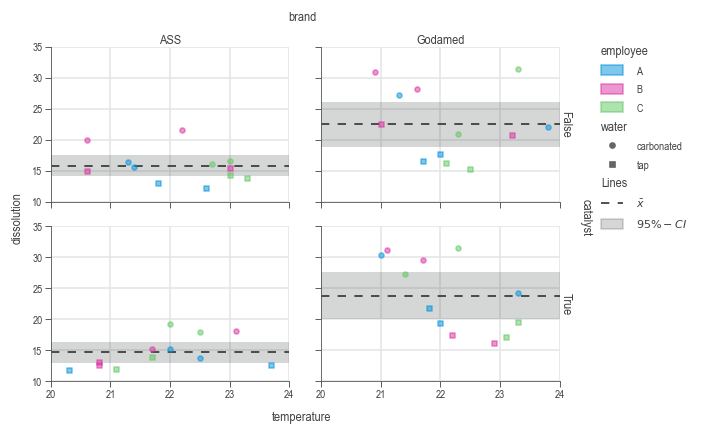

In [3]:
# dsp.style.use('seaborn')
chart = dsp.MultivariateChart(
        source=df,
        target='dissolution',
        feature='temperature',
        hue='employee',
        shape='water',
        col='brand',
        row='catalyst',
        stretch_figsize=False
    ).plot(
        dsp.Scatter
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        feature_label=True,
        target_label=True
    )

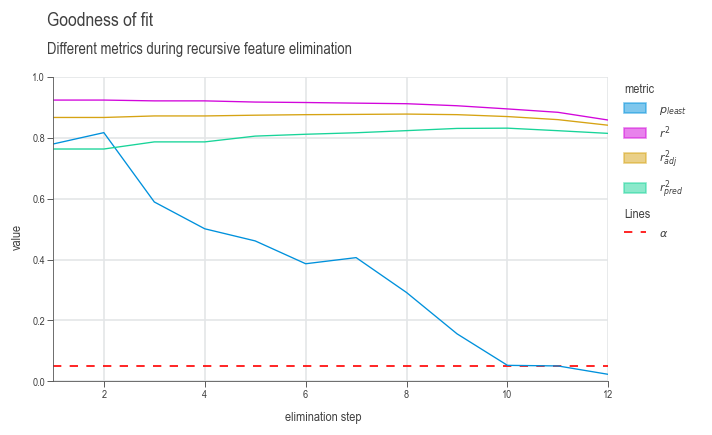

In [4]:
ALPHA = 0.05
model = dsp.LinearModel(
    source=df,
    target='dissolution',
    features=[
        'employee',
        'stirrer',
        'brand',
        'catalyst',
        'water'],
    disturbances=['temperature'],
    alpha=ALPHA,
    order=2)

df_gof = pd.concat(model.recursive_elimination())

# rename columns for mathematical notation
columns_map = {
    'p_least': '$p_{least}$',
    'r2': '$r^2$',
    'r2_adj': '$r^2_{adj}$',
    'r2_pred': '$r^2_{pred}$'}
data = df_gof.rename(columns=columns_map)

# reshape into long format
data = pd.melt(
    data, value_vars=columns_map.values(), var_name='metric')

chart = dsp.SingleChart(
        source=data,
        target='value',
        hue='metric'
    ).plot(
        dsp.Line
    ).stripes(
        stripes=[dsp.StripeLine(r'\alpha', ALPHA, color='red')]
    ).label(
        fig_title='Goodness of fit',
        sub_title='Different metrics during recursive feature elimination',
        target_label=True,
        feature_label='elimination step'
    )
_ = chart.axes[0, 0].set(xlim=(1, len(df_gof)), ylim=(0, 1))

formula:
dissolution ~ 16.0792 + 2.3750*employee[T.B] + 0.8375*employee[T.C] + 10.7500*brand[T.Godamed] - 3.8000*water[T.tap] - 5.7167*brand[T.Godamed]:water[T.tap]

Model summary:
   hierarchical least_parameter   p_least         s         aic        r2  \
0          True        employee  0.023298  2.374693  224.835935  0.857379   

   r2_adj   r2_pred  
0  0.8404  0.813719  

Parameter statistics:
                                    coef   std err          t             p  \
Intercept                      16.079167  0.839581  19.151424  2.275979e-22   
employee[T.B]                   2.375000  0.839581   2.828793  7.132978e-03   
employee[T.C]                   0.837500  0.839581   0.997522  3.242240e-01   
brand[T.Godamed]               10.750000  0.969464  11.088598  4.695450e-14   
water[T.tap]                   -3.800000  0.969464  -3.919690  3.212100e-04   
brand[T.Godamed]:water[T.tap]  -5.716667  1.371030  -4.169616  1.493044e-04   

                                  ci_low     ci_upp  
Intercept                      14.384824  17.773509  
employee[T.B]                   0.680657   4.069343  
employee[T.C]                  -0.856843   2.531843  
brand[T.Godamed]                8.793542  12.706458  
water[T.tap]                   -5.756458  -1.843542  
brand[T.Godamed]:water[T.tap]  -8.483516  -2.949817  

Analysis of variance:
Typ-I        DF          SS          MS           F             p        n2
Source                                                                     
employee      2   46.431667   23.215833    4.116891  2.329817e-02  0.027960
brand         1  747.340833  747.340833  132.526821  1.424173e-14  0.450027
water         1  532.000833  532.000833   94.340328  2.657815e-12  0.320355
brand:water   1   98.040833   98.040833   17.385695  1.493044e-04  0.059037
Residual     42  236.845000    5.639167         NaN           NaN  0.142621

Variance inflation factor:
             DF  VIF      GVIF  Threshold  Collinear               Method
Intercept     1  5.0  2.236068   2.236068       True            R_squared
employee      2  1.0       1.0   1.495349      False          generalized
brand         1  1.0       1.0   2.236068      False            R_squared
water         1  1.0       1.0   2.236068      False            R_squared
brand:water   1  1.0       1.0   2.236068      False  single_order-2_term

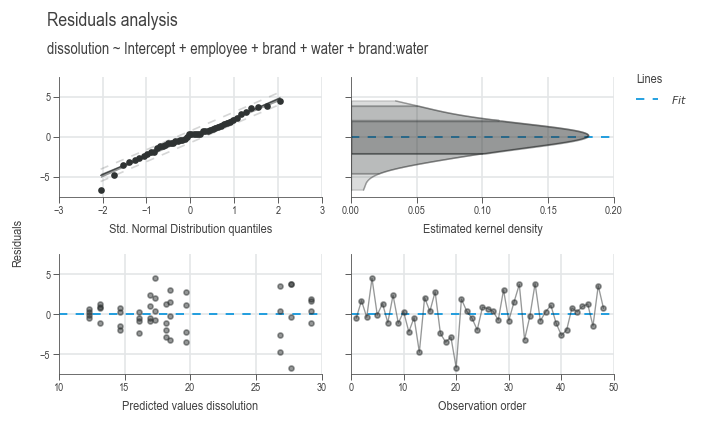

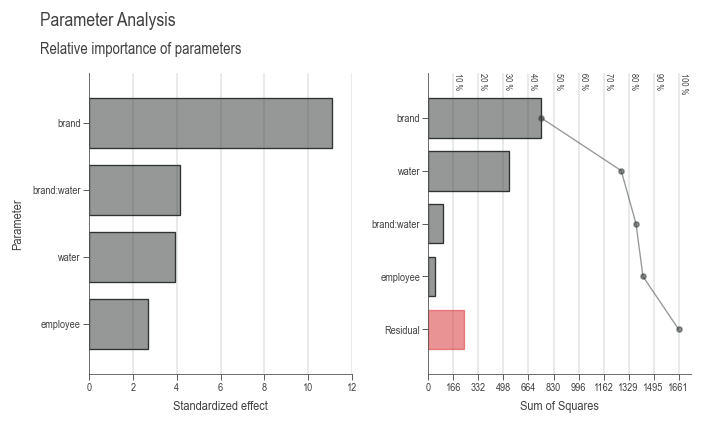

In [5]:
dsp.ResidualsCharts(model).plot().stripes().label()
dsp.ParameterRelevanceCharts(model).plot().label()
model

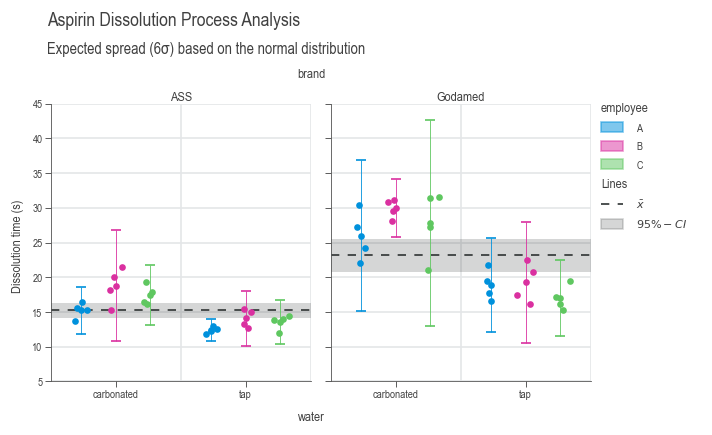

In [6]:
chart = dsp.MultivariateChart(
        source=df,
        target='dissolution',
        feature='water',
        col='brand',
        hue='employee',
        dodge=True,
    ).plot(
        dsp.Jitter
    ).plot(
        dsp.SpreadWidth,
        agreement=6,
        strategy='norm',
        bars_same_color=True
    ).stripes(
        mean=True,
        confidence=0.95
    ).label(
        fig_title='Aspirin Dissolution Process Analysis',
        sub_title='Expected spread (6σ) based on the normal distribution',
        feature_label=True,
        target_label='Dissolution time (s)'
    )

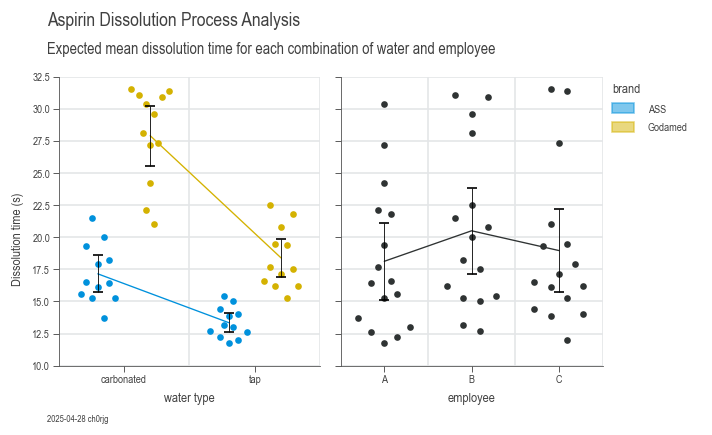

In [7]:
chart = dsp.JointChart(
        source=df,
        target='dissolution',
        feature=('water', 'employee'),
        hue=('brand', ''),
        ncols=2,
        nrows=1,
        sharey=True,
        dodge=True,
    )
for i in range(chart.n_axes):
    chart.plot(
        dsp.CenterLocation,
        show_center=False,
    ).plot(
        dsp.MeanTest,
        n_groups=1,
        show_center=False,
        on_last_axes=True
    ).plot(
        dsp.Beeswarm,
        on_last_axes=True
    )

chart.label(
    fig_title='Aspirin Dissolution Process Analysis',
    sub_title='Expected mean dissolution time for each combination of water and employee',
    feature_label=('water type', 'employee'),
    target_label='Dissolution time (s)',
    info=True
)
